In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import datetime
import gensim
import random
import re
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
#import statsmodels.api as sm
sns.set()
%matplotlib inline
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

### Preprocess

In [2]:
news = pd.read_csv('./Dataset/News_Final.csv',parse_dates=['PublishDate'])
# fe = pd.read_csv('./Dataset/Facebook_Economy.csv')

#keep the news that is on all three platforms
F = news[news['Facebook']>0].Facebook
L = news[news['LinkedIn']>0].LinkedIn
G = news[news['GooglePlus']>0].GooglePlus
news['num_platform'] = news["Facebook"].map(str) + ',' + news["GooglePlus"].map(str)+  ',' + news['LinkedIn'].map(str)
news['num_platform'] = news['num_platform'].apply(lambda x: [int(num) for num in x.split(',')])
news['num_platforms'] = news['num_platform'].apply(lambda x: 3 - x.count(-1)-x.count(0))
news_df = news[news['num_platforms']==3]

#Create Source Rank categorical labels
source_df = pd.DataFrame(news_df.Source.value_counts())
thrsd_1 = int(len(source_df)*0.01) #17
thrsd_5 = int(len(source_df)*0.05) #69
thrsd_20 = int(len(source_df)*0.2) #260 #the rest: 1386 
#Justify: I chose 20% as threshold because after 20%, 
#post per souces is lower than 10, which can be considered as a low-frequency-post number.  
source_df['source_rank'] = source_df['Source'].apply(lambda x: np.nan)
source_df['source_rank'][:thrsd_1]= 'Top_1%'
source_df['source_rank'][thrsd_1:thrsd_5]= 'Top_5%'
source_df['source_rank'][thrsd_5:thrsd_20]= 'Top_20%'
source_df['source_rank'][thrsd_20:] = 'Others'

source_df = source_df.reset_index()
source_df.columns = ['Source', 'num_post','source_rank']
news_df = news_df.merge(source_df, on = 'Source')

# Create news popularity rank categorical labels
thrsd_1 = int(len(news_df)*0.01) #17
thrsd_5 = int(len(news_df)*0.05) #69
thrsd_25 = int(len(news_df)*0.25)

def cal_thrsd(column):
    column = column.sort_values(ascending = False)
    return column.iloc[thrsd_1], column.iloc[thrsd_5], column.iloc[thrsd_25] 

facebook_thrsd = cal_thrsd(news_df.Facebook)
google_thrsd = cal_thrsd(news_df.GooglePlus)
link_thrsd = cal_thrsd(news_df.LinkedIn)

def create_rank(x, thrsd):
    if x>=thrsd[0]:
        return 'Top_1%'
    elif x>= thrsd[1]:
        return 'Top_5%'
    elif x>= thrsd[2]:
        return 'Top_25%'
    else:
        return 'Others'
    
news_df['Face_pop_rank'] = news_df['Facebook'].apply(lambda x: create_rank(x, facebook_thrsd))
news_df['Google_pop_rank'] = news_df['GooglePlus'].apply(lambda x: create_rank(x, google_thrsd))
news_df['LinkedIn_pop_rank'] = news_df['LinkedIn'].apply(lambda x: create_rank(x, link_thrsd))

### Explore lexical features

#### Title Length / Headline Length

In [3]:
news_df.columns

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'SentimentTitle', 'SentimentHeadline', 'Facebook', 'GooglePlus',
       'LinkedIn', 'num_platform', 'num_platforms', 'num_post', 'source_rank',
       'Face_pop_rank', 'Google_pop_rank', 'LinkedIn_pop_rank'],
      dtype='object')

In [4]:
news_df['title_length'] = news_df.Title.apply(lambda x : len(x.split()))
news_df['Headline_length'] = news_df.Headline.apply(lambda x : len(x.split()))

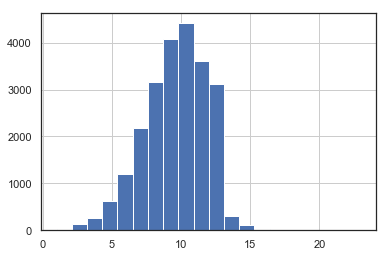

In [5]:
news_df.title_length.hist(bins=20)

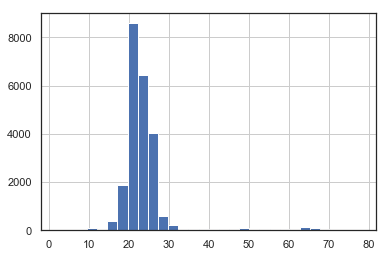

In [6]:
news_df.Headline_length.hist(bins=30)

In [7]:
news_df.groupby('Face_pop_rank').Headline_length.mean()

Face_pop_rank
Others     24.107182
Top_1%     22.243590
Top_25%    23.351547
Top_5%     22.867095
Name: Headline_length, dtype: float64

Text(0, 0.5, 'Title length')

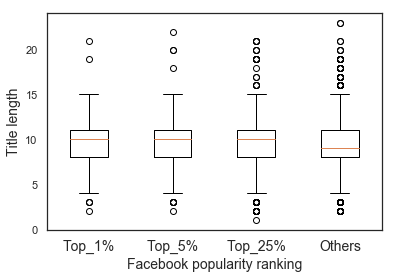

In [8]:
top_1_f = news_df[news_df['Face_pop_rank']=='Top_1%'].title_length
top_5_f = news_df[news_df['Face_pop_rank']=='Top_5%'].title_length
top_20_f = news_df[news_df['Face_pop_rank']=='Top_25%'].title_length
top_other_f = news_df[news_df['Face_pop_rank']=='Others'].title_length

plt.boxplot([top_1_f, top_5_f, top_20_f, top_other_f]);
plt.xticks([1,2,3,4],['Top_1%', 'Top_5%', 'Top_25%','Others'], fontsize = 14);
plt.xlabel('Facebook popularity ranking',fontsize = 14)
plt.ylabel('Title length',fontsize = 14)
#plt.title('', fontsize = 15)

Text(0, 0.5, 'Headline length')

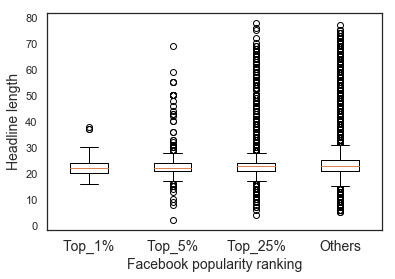

In [10]:
top_1_f = news_df[news_df['Face_pop_rank']=='Top_1%'].Headline_length
top_5_f = news_df[news_df['Face_pop_rank']=='Top_5%'].Headline_length
top_20_f = news_df[news_df['Face_pop_rank']=='Top_25%'].Headline_length
top_other_f = news_df[news_df['Face_pop_rank']=='Others'].Headline_length

plt.boxplot([top_1_f, top_5_f, top_20_f, top_other_f]);
plt.xticks([1,2,3,4],['Top_1%', 'Top_5%', 'Top_25%','Others'], fontsize = 14);
plt.xlabel('Facebook popularity ranking',fontsize = 14)
plt.ylabel('Headline length',fontsize = 14)
#plt.title('', fontsize = 15)

There is no clear connection between the popularity and the text length. 

In [11]:
# preprocess text
# generate bow features
# PCA -- not work
# train_test_split
# fit and cross validation
# evaluate and print result 
# solve the problem of unbalanced data --- Key problem!!!

### Preprocess both titles and headings

In [11]:
def preprocess(title, only_char=False, lower=True, stop_remove=True, stemming=True):
    title = re.sub(r'[^\x00-\x7F]+',' ', title)
    if lower: 
        title = title.lower()
    if only_char:
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(title)
        title = ' '.join(tokens)
    tokens = word_tokenize(title)
    if stop_remove:
        tokens = [w for w in tokens if not w in stopwords.words('english')]
  # also remove one-length word
    tokens = [w for w in tokens if len(w) > 1]
    return " ".join(tokens)

In [14]:
news_df['title_prep'] = news_df.Title.apply(lambda x: preprocess(x))

In [15]:
news_df['headline_prep'] = news_df.Headline.apply(lambda x: preprocess(x))

In [16]:
news_df.to_csv('preprocessed_text_news_df.csv')